In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [108]:
df = pd.read_csv('/content/drive/MyDrive/UU/BTC-USD (BaoCao).csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,3853.757080,3907.795410,3851.692383,3859.583740,3859.583740,7661247975
1,2019-03-02,3855.318115,3874.607422,3832.127930,3864.415039,3864.415039,7578786076
2,2019-03-03,3862.266113,3875.483643,3836.905762,3847.175781,3847.175781,7253558152
3,2019-03-04,3845.091553,3867.381836,3733.749756,3761.557129,3761.557129,9029175788
4,2019-03-05,3759.832520,3903.916748,3745.183105,3896.375000,3896.375000,10174126415


In [109]:

df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace=True)

In [112]:
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

In [113]:

# Chuẩn hóa dữ liệu
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close).reshape(-1, 1))

In [115]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1920 entries, 2019-03-01 to 2024-06-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1920 non-null   float64
 1   High       1920 non-null   float64
 2   Low        1920 non-null   float64
 3   Close      1920 non-null   float64
 4   Adj Close  1920 non-null   float64
 5   Volume     1920 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 105.0 KB


In [116]:
cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']  # Correct the column name 'Adj Close'
df = df[cols]
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-01,3853.757080,3907.795410,3851.692383,3859.583740,3859.583740,7661247975
2019-03-02,3855.318115,3874.607422,3832.127930,3864.415039,3864.415039,7578786076
2019-03-03,3862.266113,3875.483643,3836.905762,3847.175781,3847.175781,7253558152
2019-03-04,3845.091553,3867.381836,3733.749756,3761.557129,3761.557129,9029175788
2019-03-05,3759.832520,3903.916748,3745.183105,3896.375000,3896.375000,10174126415


In [117]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def calculate_vif(df):
    """Calculate Variance Inflation Factor (VIF) for each variable."""
    vif_df = pd.DataFrame()
    vif_df["variables"] = df.columns
    vif_df["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_df

def cointegration_test(df, alpha=0.05, max_vif=10):
    """Perform Johanson's Cointegration Test and Report Summary"""
    # Convert numeric columns to float
    df_numeric = df.select_dtypes(include=['number']).astype(float)

    # Drop any columns with all zero values
    df_numeric = df_numeric.loc[:, (df_numeric != 0).any(axis=0)]

    # Drop constant columns to handle perfect multicollinearity
    df_numeric = df_numeric.loc[:, (df_numeric != df_numeric.iloc[0]).any()]

    # Calculate VIF and drop columns with VIF higher than the threshold
    while True:
        vif_df = calculate_vif(df_numeric)
        max_vif_value = vif_df['VIF'].max()
        if max_vif_value > max_vif:
            remove_col = vif_df.sort_values('VIF', ascending=False)['variables'].iloc[0]
            print(f"Removing {remove_col} with VIF {max_vif_value}")
            df_numeric = df_numeric.drop(columns=[remove_col])
        else:
            break

    out = coint_johansen(df_numeric, -1, 5)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]

    def adjust(val, length=6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df_numeric.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace, 2), 9), ">", adjust(cvt, 8), ' =>  ', trace > cvt)

# Example usage with your dataframe df
cointegration_test(df)

Removing Close with VIF inf
Removing High with VIF 7250.579670751399
Removing Low with VIF 2825.230461797909
Removing Open with VIF 853.917276853635
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Adj Close ::  21.82     > 12.3212   =>   True
Volume ::  0.28      > 4.1296    =>   False


In [118]:
df = df.sort_values(by='Date', ascending=True)

In [143]:
# Train, test
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

time_series = df[cols]
train_data = time_series[:int(0.8*len(time_series))]
test_data = time_series[int(0.8*len(time_series)):]

Error fitting model with lag 2. Skipping.
Error fitting model with lag 5. Skipping.
Error fitting model with lag 7. Skipping.
Error fitting model with lag 8. Skipping.
Error fitting model with lag 10. Skipping.


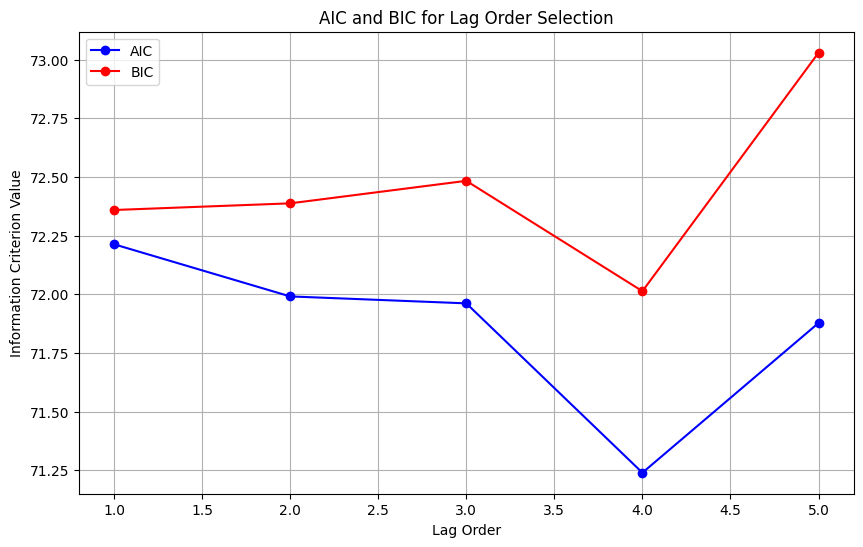

Optimal lag order based on AIC: 4
Optimal lag order based on BIC: 4


In [144]:
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import aic, bic
import numpy as np

# Tạo danh sách các giá trị lag order cần kiểm tra
maxlags = 10  # Số lượng lag order tối đa để kiểm tra

# Khởi tạo list để lưu trữ các giá trị AIC và BIC
aic_values = []
bic_values = []

for lag in range(1, maxlags+1):
    model = VAR(train_data)
    try:
        results = model.fit(lag)
        aic_values.append(results.aic)
        bic_values.append(results.bic)
    except np.linalg.LinAlgError:
        print(f"Error fitting model with lag {lag}. Skipping.")
        continue  # Skip to the next lag if an error occurs

# Vẽ đồ thị AIC và BIC (only if any models were successfully fit)
if aic_values:  # Check if aic_values is not empty
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(range(1, len(aic_values) + 1), aic_values, marker='o', linestyle='-', color='b', label='AIC')
    plt.plot(range(1, len(bic_values) + 1), bic_values, marker='o', linestyle='-', color='r', label='BIC')
    plt.xlabel('Lag Order')
    plt.ylabel('Information Criterion Value')
    plt.title('AIC and BIC for Lag Order Selection')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Tìm lag order tối ưu dựa trên AIC hoặc BIC
    optimal_lag_aic = np.argmin(aic_values) + 1  # +1 vì index bắt đầu từ 0
    optimal_lag_bic = np.argmin(bic_values) + 1  # +1 vì index bắt đầu từ 0

    print(f'Optimal lag order based on AIC: {optimal_lag_aic}')
    print(f'Optimal lag order based on BIC: {optimal_lag_bic}')
else:
    print("No models could be fit successfully. Check for multicollinearity or singularity issues in your data.")

In [145]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [146]:
# ADF Test on each column
df_diff = df.diff().dropna()  # Calculate first differences and drop missing values

for name, column in df_diff.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -46.7778
 No. Lags Chosen       = 0
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.2078
 No. Lags Chosen       = 26
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05

In [147]:
import warnings
warnings.filterwarnings("ignore")

In [148]:
df_diff = train_data.diff().dropna()
df_diff

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-02,1.561035,-33.187988,-19.564453,4.831299,4.831299,-8.246190e+07
2019-03-03,6.947998,0.876221,4.777832,-17.239258,-17.239258,-3.252279e+08
2019-03-04,-17.174560,-8.101807,-103.156006,-85.618652,-85.618652,1.775618e+09
2019-03-05,-85.259033,36.534912,11.433349,134.817871,134.817871,1.144951e+09
2019-03-06,137.248535,15.593750,126.277588,7.567627,7.567627,-9.988349e+08
...,...,...,...,...,...,...
2023-05-10,-40.431640,501.287109,-491.931641,-37.019532,-37.019532,6.527432e+09
2023-05-11,-33.550781,-700.746094,-101.843750,-620.966796,-620.966796,-3.931681e+09
2023-05-12,-633.423829,-566.294922,-903.396484,-195.798829,-195.798829,2.589256e+09


In [149]:
# ADF Test on each column
for name, column in df_diff.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.409
 No. Lags Chosen       = 8
 Critical value 1%     = -3.435
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -17.6732
 No. Lags Chosen       = 3
 Critical value 1%     = -3.435
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05


In [150]:
model = VAR(df_diff)

In [151]:


import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Assuming df_diff is your differenced DataFrame

# ADF Test on each column
for name, column in df_diff.items():
    result = adfuller(column) # Remove the 'name' argument
    print(f'ADF Statistic for {name}: {result[0]}') # Use f-string to print the name
    print(f'p-value: {result[1]}')
    print('\n')

# Check for multicollinearity
correlation_matrix = df_diff.corr()
print(correlation_matrix)

ADF Statistic for Open: -12.409025097146758
p-value: 4.3859919592332166e-23


ADF Statistic for High: -17.673158573182764
p-value: 3.6368869532070574e-30


ADF Statistic for Low: -7.874019913816469
p-value: 4.8985523818503254e-12


ADF Statistic for Close: -7.6954614812748146
p-value: 1.3831435216317456e-11


ADF Statistic for Adj Close: -7.6954614812748146
p-value: 1.3831435216317456e-11


ADF Statistic for Volume: -16.997111895371493
p-value: 8.783143312931539e-30


               Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.551083  0.420309 -0.030056  -0.030056  0.020318
High       0.551083  1.000000  0.441290  0.544941   0.544941  0.120476
Low        0.420309  0.441290  1.000000  0.590783   0.590783 -0.297498
Close     -0.030056  0.544941  0.590783  1.000000   1.000000 -0.062623
Adj Close -0.030056  0.544941  0.590783  1.000000   1.000000 -0.062623
Volume     0.020318  0.120476 -0.297498 -0.062623  -0.062623  1.000000


In [152]:
fitted_model = model.fit() # Fit the VAR model and store it

lag_order = fitted_model.k_ar
print(lag_order)

1


In [153]:

predictions = fitted_model.forecast(df_diff.values[-lag_order:], steps=len(test_data))
predictions

array([[ 1.45630518e+02,  5.25229280e+01,  1.36998282e+02,
         1.85845510e+01,  1.85845510e+01,  1.86477144e+08],
       [ 1.83461947e+01,  3.18996062e+01, -1.47225079e+01,
         1.26135956e+01,  1.26135956e+01, -8.67959188e+07],
       [ 1.24010327e+01,  6.88553137e+00,  2.76721202e+01,
         1.65984623e+01,  1.65984623e+01,  1.16228425e+08],
       ...,
       [ 1.50418417e+01,  1.51992896e+01,  1.49441399e+01,
         1.50363627e+01,  1.50363627e+01,  1.73199957e+06],
       [ 1.50418417e+01,  1.51992896e+01,  1.49441399e+01,
         1.50363627e+01,  1.50363627e+01,  1.73199957e+06],
       [ 1.50418417e+01,  1.51992896e+01,  1.49441399e+01,
         1.50363627e+01,  1.50363627e+01,  1.73199957e+06]])

In [154]:
# Calculate the starting index based on the length of the predictions array
start_index = len(df) - len(predictions)

df_forecast = pd.DataFrame(predictions, index=df.index[start_index:], columns=[col + '_1d' for col in df.columns])
df_forecast

,Open_1d,High_1d,Low_1d,Close_1d,Adj Close_1d,Volume_1d
Date,,,,,,
2023-05-15,145.630518,52.522928,136.998282,18.584551,18.584551,1.864771e+08
2023-05-16,18.346195,31.899606,-14.722508,12.613596,12.613596,-8.679592e+07
2023-05-17,12.401033,6.885531,27.672120,16.598462,16.598462,1.162284e+08
2023-05-18,16.682538,19.360194,9.924018,14.424922,14.424922,-8.680621e+07
2023-05-19,14.408535,13.302096,16.871611,15.239015,15.239015,5.941781e+07
...,...,...,...,...,...,...
2024-05-28,15.041842,15.199290,14.944140,15.036363,15.036363,1.732000e+06
2024-05-29,15.041842,15.199290,14.944140,15.036363,15.036363,1.732000e+06
2024-05-30,15.041842,15.199290,14.944140,15.036363,15.036363,1.732000e+06


In [155]:


def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns  # Get the actual column names from df_train
    for col in columns:
        # Use the correct column names from df_train when creating forecasted columns
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(train_data, df_forecast)
# Now, define fc_cols based on the actual forecasted column names
fc_cols = [col + '_forecast' for col in train_data.columns]
df_results = df_results[fc_cols]
df_results

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
Date,,,,,,
2023-05-15,26934.605127,27203.499491,26798.353751,26949.223223,26949.223223,1.020134e+10
2023-05-16,26952.951322,27235.399097,26783.631243,26961.836819,26961.836819,1.011454e+10
2023-05-17,26965.352355,27242.284629,26811.303363,26978.435281,26978.435281,1.023077e+10
2023-05-18,26982.034892,27261.644823,26821.227381,26992.860202,26992.860202,1.014396e+10
2023-05-19,26996.443427,27274.946918,26838.098991,27008.099218,27008.099218,1.020338e+10
...,...,...,...,...,...,...
2024-05-28,32637.296610,32975.268492,32441.641278,32646.692659,32646.692659,1.083110e+10
2024-05-29,32652.338452,32990.467781,32456.585417,32661.729021,32661.729021,1.083283e+10
2024-05-30,32667.380293,33005.667071,32471.529557,32676.765384,32676.765384,1.083456e+10


In [156]:

# Forecasting 30 days ahead (adjust the 'steps' parameter as needed)
predictions_future = fitted_model.forecast(test_data.diff().values[-10:], steps=30)

last_date = df.index[-1]
start_date = last_date + pd.Timedelta(days=1)

# Create the index for the forecasted days
forecast_index = pd.date_range(start=start_date, periods=30, freq='D')

# Create a DataFrame for the forecasted values
df_forecast_30days = pd.DataFrame(predictions_future, index=forecast_index, columns=df.columns + '_1d')

print(df_forecast_30days.head())

               Open_1d     High_1d      Low_1d   Close_1d  Adj Close_1d  \
2024-06-02  224.707754  491.556370 -382.838809 -43.077794    -43.077794   
2024-06-03  -44.984176 -198.588668  195.352266  34.148607     34.148607   
2024-06-04   34.119771  114.786207  -57.584606   9.885438      9.885438   
2024-06-05   10.367780  -30.942823   40.568000  15.351754     15.351754   
2024-06-06   14.881964   36.323497    7.991360  16.066001     16.066001   

               Volume_1d  
2024-06-02  2.600272e+09  
2024-06-03  7.938857e+08  
2024-06-04 -1.266784e+09  
2024-06-05  1.002529e+09  
2024-06-06 -6.495802e+08  


In [157]:


def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Create forecasted columns using '_forecast' suffix
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results_30days = invert_transformation(test_data, df_forecast_30days)

# Define fc_cols based on the actual forecasted column names in df_results_30days
fc_cols = [col for col in df_results_30days.columns if '_forecast' in col]
df_results_30days = df_results_30days[fc_cols]
df_results_30days.head()

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,67714.317129,68331.321995,67003.356504,67663.859706,67663.859706,1.424177e+10
2024-06-03,67669.332953,68132.733327,67198.708770,67698.008313,67698.008313,1.503565e+10
2024-06-04,67703.452724,68247.519534,67141.124164,67707.893751,67707.893751,1.376887e+10
2024-06-05,67713.820504,68216.576711,67181.692163,67723.245505,67723.245505,1.477140e+10
2024-06-06,67728.702467,68252.900208,67189.683524,67739.311506,67739.311506,1.412182e+10


In [158]:
df_results_30days = invert_transformation(test_data, df_forecast_30days)
df_results_30days = df_results_30days[fc_cols]
df_results_30days

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,67714.317129,68331.321995,67003.356504,67663.859706,67663.859706,1.424177e+10
2024-06-03,67669.332953,68132.733327,67198.708770,67698.008313,67698.008313,1.503565e+10
2024-06-04,67703.452724,68247.519534,67141.124164,67707.893751,67707.893751,1.376887e+10
2024-06-05,67713.820504,68216.576711,67181.692163,67723.245505,67723.245505,1.477140e+10
2024-06-06,67728.702467,68252.900208,67189.683524,67739.311506,67739.311506,1.412182e+10
2024-06-07,67745.132984,68258.564112,67205.026535,67753.221152,67753.221152,1.450945e+10
2024-06-08,67758.807411,68278.005975,67221.339169,67769.129366,67769.129366,1.429519e+10
2024-06-09,67774.871718,68291.344976,67234.818981,67783.577356,67783.577356,1.441320e+10
2024-06-10,67789.235154,68307.347964,67250.875799,67798.981937,67798.981937,1.435410e+10
2024-06-11,67804.697292,68322.205253,67265.081149,67813.798786,67813.798786,1.438696e+10


In [159]:

# Forecasting 60 days ahead (adjust the 'steps' parameter as needed)
predictions_future = fitted_model.forecast(test_data.diff().values[-10:], steps=60)

last_date = df.index[-1]
start_date = last_date + pd.Timedelta(days=1)

# Create the index for the forecasted days
forecast_index = pd.date_range(start=start_date, periods=60, freq='D')

# Create a DataFrame for the forecasted values
df_forecast_60days = pd.DataFrame(predictions_future, index=forecast_index, columns=df.columns + '_1d')

print(df_forecast_60days.head())

               Open_1d     High_1d      Low_1d   Close_1d  Adj Close_1d  \
2024-06-02  224.707754  491.556370 -382.838809 -43.077794    -43.077794   
2024-06-03  -44.984176 -198.588668  195.352266  34.148607     34.148607   
2024-06-04   34.119771  114.786207  -57.584606   9.885438      9.885438   
2024-06-05   10.367780  -30.942823   40.568000  15.351754     15.351754   
2024-06-06   14.881964   36.323497    7.991360  16.066001     16.066001   

               Volume_1d  
2024-06-02  2.600272e+09  
2024-06-03  7.938857e+08  
2024-06-04 -1.266784e+09  
2024-06-05  1.002529e+09  
2024-06-06 -6.495802e+08  


In [160]:
df_results_60days = invert_transformation(test_data, df_forecast_60days)
df_results_60days = df_results_60days[fc_cols]
df_results_60days

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,67714.317129,68331.321995,67003.356504,67663.859706,67663.859706,1.424177e+10
2024-06-03,67669.332953,68132.733327,67198.708770,67698.008313,67698.008313,1.503565e+10
2024-06-04,67703.452724,68247.519534,67141.124164,67707.893751,67707.893751,1.376887e+10
2024-06-05,67713.820504,68216.576711,67181.692163,67723.245505,67723.245505,1.477140e+10
2024-06-06,67728.702467,68252.900208,67189.683524,67739.311506,67739.311506,1.412182e+10
2024-06-07,67745.132984,68258.564112,67205.026535,67753.221152,67753.221152,1.450945e+10
2024-06-08,67758.807411,68278.005975,67221.339169,67769.129366,67769.129366,1.429519e+10
2024-06-09,67774.871718,68291.344976,67234.818981,67783.577356,67783.577356,1.441320e+10
2024-06-10,67789.235154,68307.347964,67250.875799,67798.981937,67798.981937,1.435410e+10
2024-06-11,67804.697292,68322.205253,67265.081149,67813.798786,67813.798786,1.438696e+10


In [161]:

# Forecasting 90 days ahead (adjust the 'steps' parameter as needed)
predictions_future = fitted_model.forecast(test_data.diff().values[-10:], steps=90)

last_date = df.index[-1]
start_date = last_date + pd.Timedelta(days=1)

# Create the index for the forecasted days
forecast_index = pd.date_range(start=start_date, periods=90, freq='D')

# Create a DataFrame for the forecasted values
df_forecast_90days = pd.DataFrame(predictions_future, index=forecast_index, columns=df.columns + '_1d')

print(df_forecast_90days.head())

               Open_1d     High_1d      Low_1d   Close_1d  Adj Close_1d  \
2024-06-02  224.707754  491.556370 -382.838809 -43.077794    -43.077794   
2024-06-03  -44.984176 -198.588668  195.352266  34.148607     34.148607   
2024-06-04   34.119771  114.786207  -57.584606   9.885438      9.885438   
2024-06-05   10.367780  -30.942823   40.568000  15.351754     15.351754   
2024-06-06   14.881964   36.323497    7.991360  16.066001     16.066001   

               Volume_1d  
2024-06-02  2.600272e+09  
2024-06-03  7.938857e+08  
2024-06-04 -1.266784e+09  
2024-06-05  1.002529e+09  
2024-06-06 -6.495802e+08  


In [162]:


df_results_90days = invert_transformation(test_data, df_forecast_90days)
df_results_90days = df_results_90days[fc_cols]
df_results_90days

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Adj Close_forecast,Volume_forecast
2024-06-02,67714.317129,68331.321995,67003.356504,67663.859706,67663.859706,1.424177e+10
2024-06-03,67669.332953,68132.733327,67198.708770,67698.008313,67698.008313,1.503565e+10
2024-06-04,67703.452724,68247.519534,67141.124164,67707.893751,67707.893751,1.376887e+10
2024-06-05,67713.820504,68216.576711,67181.692163,67723.245505,67723.245505,1.477140e+10
2024-06-06,67728.702467,68252.900208,67189.683524,67739.311506,67739.311506,1.412182e+10
...,...,...,...,...,...,...
2024-08-26,68947.719631,69477.452574,68401.121178,68956.643112,68956.643112,1.450815e+10
2024-08-27,68962.761472,69492.651864,68416.065317,68971.679474,68971.679474,1.450988e+10
2024-08-28,68977.803314,69507.851153,68431.009457,68986.715837,68986.715837,1.451161e+10
2024-08-29,68992.845156,69523.050443,68445.953597,69001.752200,69001.752200,1.451334e+10


In [163]:
predict_data_index_60 = pd.RangeIndex(start=len(df)+29, stop=len(df)+59, step=1)
predict_data_index_90 = pd.RangeIndex(start=len(df)+59, stop=len(df)+89, step=1)

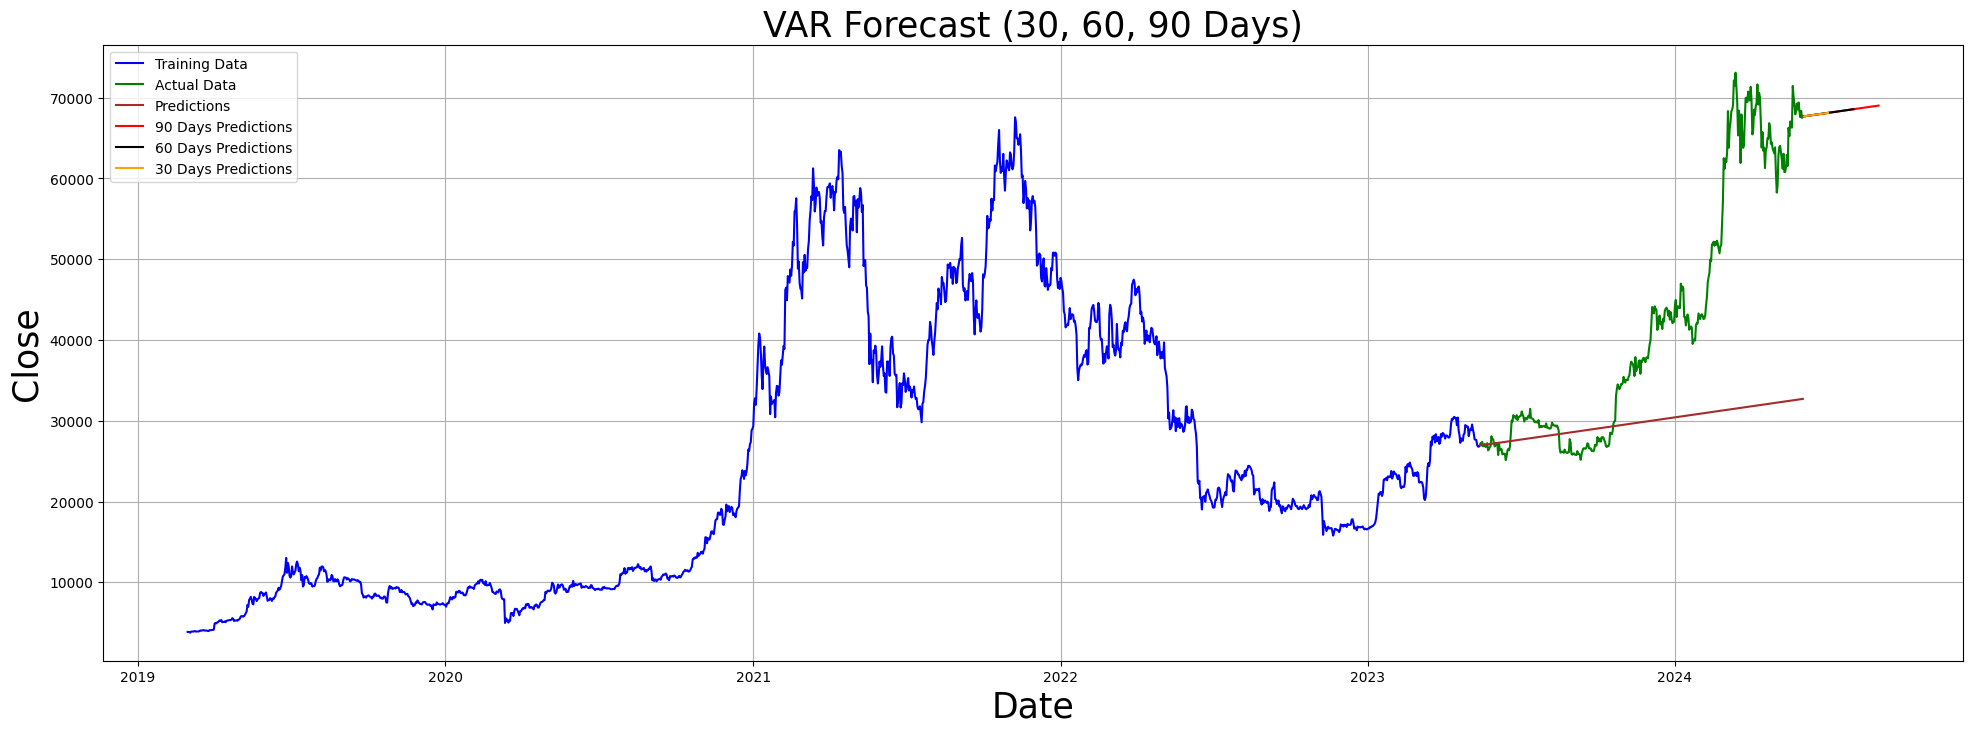

In [164]:
import matplotlib.pyplot as plt

# Assuming df_results_30days, df_results_60days, df_results_90days are your DataFrames containing forecast results
# Define the date range for plotting
start_date = '2019-01-03'
end_date = '2024-08-30'

# Plotting the data
plt.figure(figsize=(24, 8))

# Plotting the training data
plt.plot(train_data.index, train_data.Close, label='Training Data', color='blue')

# Plotting the actual test data
plt.plot(test_data.index, test_data.Close, label='Actual Data', color='green')
# Plotting the prediction data
plt.plot(test_data.index, df_results.Close_forecast, label='Predictions', color ='brown')
# Plotting the forecast results

plt.plot(df_results_90days.index, df_results_90days.Close_forecast, label='90 Days Predictions', color='red')

plt.plot(df_results_60days.index, df_results_60days.Close_forecast, label='60 Days Predictions', color='black')
plt.plot(df_results_30days.index, df_results_30days.Close_forecast, label='30 Days Predictions', color='orange')
# Adding title and labels
plt.title('VAR Forecast (30, 60, 90 Days)', fontsize=25)
plt.xlabel('Date', fontsize=25)
plt.ylabel('Close', fontsize=25)

# Adding legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [165]:

y_test = test_data.Close
y_pred = df_results.Close_forecast

In [166]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np



test_91_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_91_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
test_91_mse = np.mean((np.array(y_test) - np.array(y_pred))**2)
print('Testing RMSE:', test_91_rmse)
print('Testing MAPE:', test_91_mape)
print('Testing MSE:', test_91_mse)

Testing RMSE: 18624.93621297462
Testing MAPE: 24.282970155092627
Testing MSE: 346888248.9373733
